In [1]:
# cd to the 'lib' directory in your notebooks directory
# $ export LIBROOT=`pwd`
# Start jupyter lab from any directory
import sys, os
if (os.environ.get('LIBROOT')):
    sys.path.append(os.environ.get('LIBROOT'))

from sysInfo import sysInfo
info = sysInfo()
info.show(vList=['platform', 'python', 'esmf', 'esmpy', 'xgcm', 'xesmf',
                 'netcdf4', 'numpy', 'xarray','dask',
                 'cartopy', 'matplotlib',
                 'jupyter_core','jupyterlab','notebook',
                 'bokeh','holoviews','geoviews','datashader','panel'])

System name                             : Linux
System name                             : mom6vm
Operating system release                : 5.8.0-45-generic
Operating system version                : #51~20.04.1-Ubuntu SMP Tue Feb 23 13:46:31 UTC 2021
Hardware identifier                     : x86_64
Active conda environment                : pangeo
Conda reported versions of software:
platform                                : linux-64
python                                  : 3.9.2
esmf                                    : not installed
esmpy                                   : not installed
xgcm                                    : not installed
xesmf                                   : not installed
netcdf4                                 : 1.5.6
numpy                                   : 1.20.1
xarray                                  : 0.17.0
dask                                    : 2021.3.0
cartopy                                 : 0.18.0
matplotlib                              : not 

In [2]:
# REF: https://panel.holoviz.org/getting_started/index.html

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('assets/occupancy.csv')
data['date'] = data.date.astype('datetime64[ns]')
data = data.set_index('date')

data.tail()

Temperature  Humidity  Light         CO2  HumidityRatio  \
date                                                                           
2015-02-10 09:29:00        21.05   36.0975  433.0  787.250000       0.005579   
2015-02-10 09:29:59        21.05   35.9950  433.0  789.500000       0.005563   
2015-02-10 09:30:59        21.10   36.0950  433.0  798.500000       0.005596   
2015-02-10 09:32:00        21.10   36.2600  433.0  820.333333       0.005621   
2015-02-10 09:33:00        21.10   36.2000  447.0  821.000000       0.005612   

                     Occupancy  
date                            
2015-02-10 09:29:00          1  
2015-02-10 09:29:59          1  
2015-02-10 09:30:59          1  
2015-02-10 09:32:00          1  
2015-02-10 09:33:00          1

In [3]:
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas

%matplotlib inline

def mpl_plot(avg, highlight):
    fig = Figure()
    FigureCanvas(fig) # not needed in mpl >= 3.1
    ax = fig.add_subplot()
    avg.plot(ax=ax)
    if len(highlight): highlight.plot(style='o', ax=ax)
    return fig

def find_outliers(variable='Temperature', window=30, sigma=10, view_fn=mpl_plot):
    avg = data[variable].rolling(window=window).mean()
    residual = data[variable] - avg
    std = residual.rolling(window=window).std()
    outliers = (np.abs(residual) > std * sigma)
    return view_fn(avg, avg[outliers])

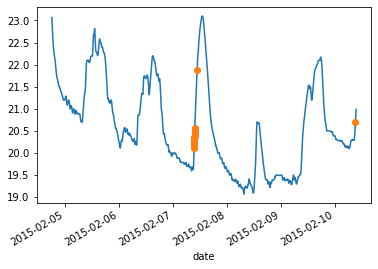

In [4]:
find_outliers(variable='Temperature', window=20, sigma=10)

Column
    [0] Column
        [0] IntSlider(end=90, name='window', start=-30, value=30, value_throttled=30)
        [1] IntSlider(end=30, name='sigma', start=-10, value=10, value_throttled=10)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00099')
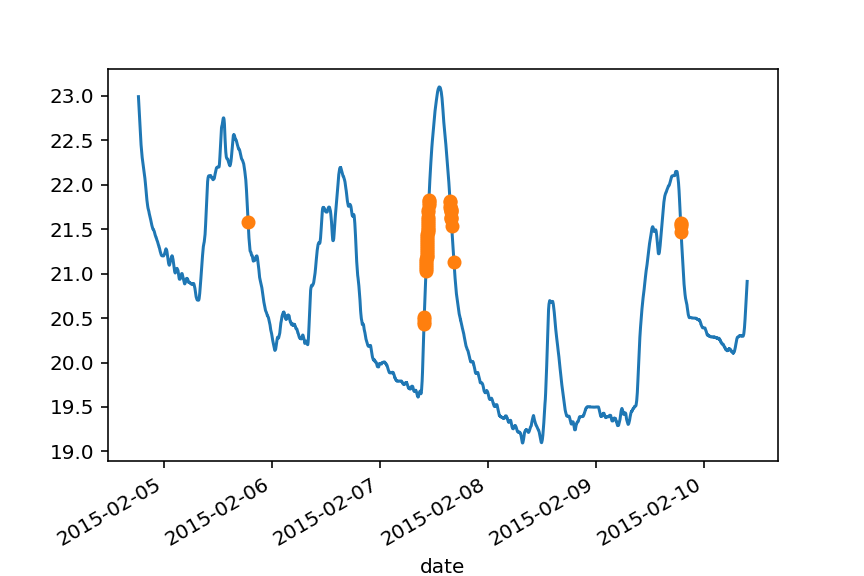

In [5]:
import panel as pn
pn.extension()

pn.interact(find_outliers)

In [6]:
kw = dict(window=(1, 60), variable=sorted(list(data.columns)), sigma=(1, 20))
i = pn.interact(find_outliers, **kw)
i.pprint()

Column
    [0] Column
        [0] Select(name='variable', options=['CO2', 'Humidity', ...], value='Temperature')
        [1] IntSlider(end=60, name='window', start=1, value=30, value_throttled=30)
        [2] IntSlider(end=20, name='sigma', start=1, value=10, value_throttled=10)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00112')


Row
    [0] Matplotlib(Figure, name='interactive00112')
    [1] Column
        [0] Markdown(str)
        [1] Select(name='variable', options=['CO2', 'Humidity', ...], value='Temperature')
        [2] IntSlider(end=60, name='window', start=1, value=30, value_throttled=30)
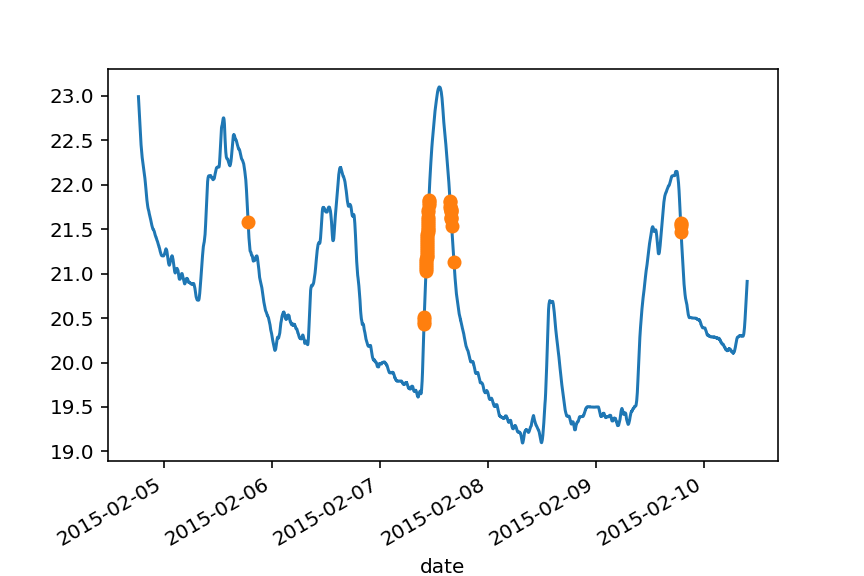

In [7]:
text = "<br>\n# Room Occupancy\nSelect the variable, and the time window for smoothing"

p = pn.Row(i[1][0], pn.Column(text, i[0][0], i[0][1]))
p

In [8]:
i[0][2]

IntSlider(end=20, name='sigma', start=1, value=10, value_throttled=10)

In [9]:
# Manual setting by instruction
i[0][2].value = 5

Row
    [0] ParamFunction(function)
    [1] Column
        [0] Markdown(str)
        [1] RadioButtonGroup(name='variable', options=['Temperature', ...], value='Temperature')
        [2] IntSlider(end=60, name='window', start=1, value=10, value_throttled=10)
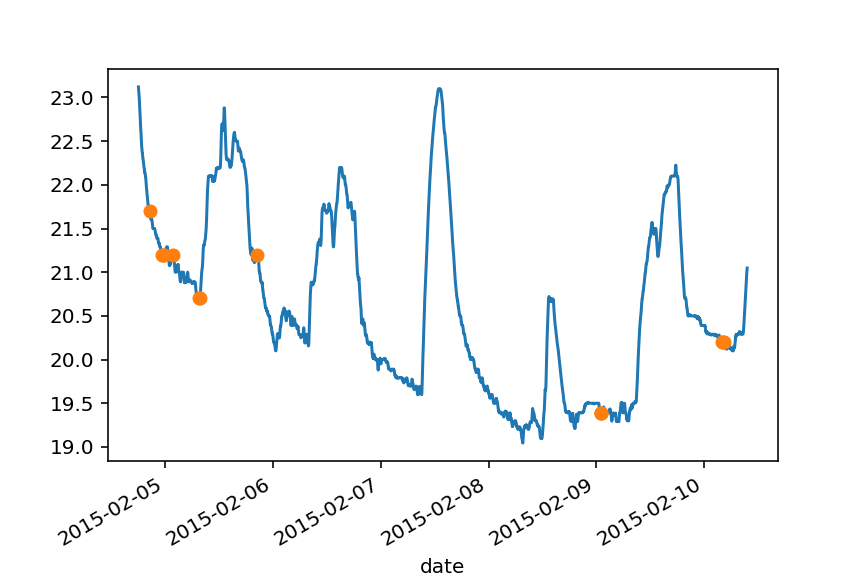

In [10]:
# Constructing a different arrangement
# pn.bind() requires a higher version of panel
import panel.widgets as pnw

variable  = pnw.RadioButtonGroup(name='variable', value='Temperature', 
                                 options=list(data.columns))
window  = pnw.IntSlider(name='window', value=10, start=1, end=60)

reactive_outliers = pn.bind(find_outliers, variable, window, 10)

widgets   = pn.Column("<br>\n# Room occupancy", variable, window)
occupancy = pn.Row(reactive_outliers, widgets)
occupancy

In [12]:
import param

class RoomOccupancy(param.Parameterized):
    variable  = param.Selector(objects=list(data.columns))
    window    = param.Integer(default=10, bounds=(1, 20))
    sigma     = param.Number(default=10, bounds=(0, 20))

    def view(self):
        return find_outliers(self.variable, self.window, self.sigma)
    
obj = RoomOccupancy()
obj

RoomOccupancy(name='RoomOccupancy00145', sigma=10, variable='Temperature', window=10)

Row
    [0] Column(margin=5, name='RoomOccupancy', width=300)
        [0] StaticText(value='<b>RoomOccupancy</b>')
        [1] Select(name='Variable', options=OrderedDict([('Temperature...]), value='Temperature')
        [2] IntSlider(end=20, name='Window', start=1, value=10, value_throttled=10)
        [3] FloatSlider(end=20, name='Sigma', value=10, value_throttled=10)
    [1] ParamMethod(method)
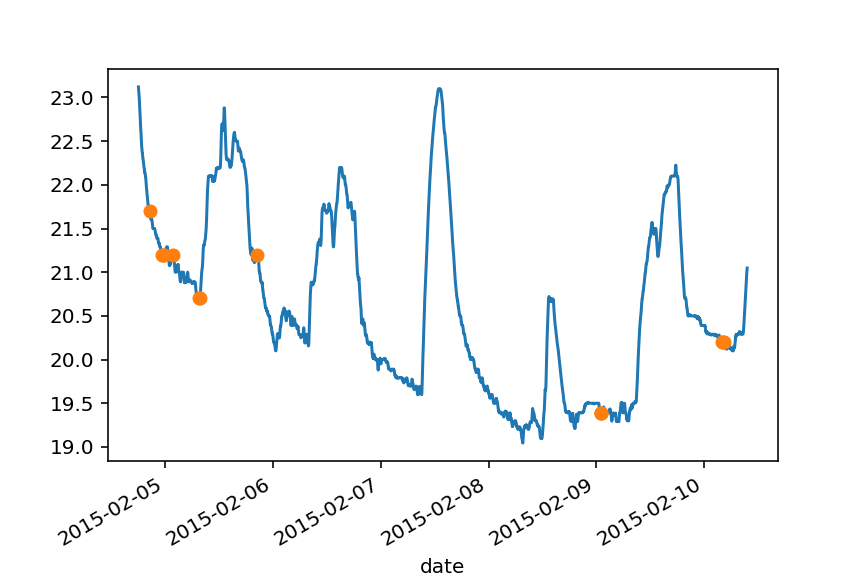

In [13]:
pn.Row(obj.param, obj.view)

In [14]:
import hvplot.pandas

def hvplot(avg, highlight):
    return avg.hvplot(height=200) * highlight.hvplot.scatter(color='orange', padding=0.1)

text2 = "## Room Occupancy\nSelect the variable and the smoothing values"
hvp   = pn.interact(find_outliers, view_fn=hvplot, **kw)
pn.Column(pn.Row(pn.panel(text2, width=400), hvp[0]), hvp[1]).servable("Occupancy")

Column
    [0] Row
        [0] Markdown(str, width=400)
        [1] Column
            [0] Select(name='variable', options=['CO2', 'Humidity', ...], value='Temperature')
            [1] IntSlider(end=60, name='window', start=1, value=30, value_throttled=30)
            [2] IntSlider(end=20, name='sigma', start=1, value=10, value_throttled=10)
    [1] Row
        [0] HoloViews(Overlay, name='interactive01619')

In [15]:
import holoviews as hv

tap = hv.streams.PointerX(x=data.index.min())

def hvplot2(avg, highlight):
    line = avg.hvplot(height=300, width=500)
    outliers = highlight.hvplot.scatter(color='orange', padding=0.1)
    tap.source = line
    return (line * outliers).opts(legend_position='top_right')

@pn.depends(tap.param.x)
def table(x):
    index = np.abs((data.index - x).astype(int)).argmin()
    return data.iloc[index]

app = pn.interact(find_outliers, view_fn=hvplot2, **kw)

pn.Row(
    pn.Column("## Room Occupancy\nHover over the plot for more information.", app[0]),
    pn.Row(app[1], table)
)

Row
    [0] Column
        [0] Markdown(str)
        [1] Column
            [0] Select(name='variable', options=['CO2', 'Humidity', ...], value='Temperature')
            [1] IntSlider(end=60, name='window', start=1, value=30, value_throttled=30)
            [2] IntSlider(end=20, name='sigma', start=1, value=10, value_throttled=10)
    [1] Row
        [0] Row
            [0] HoloViews(Overlay, name='interactive08007')
        [1] ParamFunction(function)